# ATLAS/Aliqa-Uma Stream Model

## Setup and Initialization

### Imports

In [1]:
import itertools
import pathlib
import pickle
import sys
import warnings
import shapely
import matplotlib.colors as mcl

import astropy.units as u
import brutus
import brutus.seds
import brutus.utils
import astropy.coordinates as coords
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.cm as cm
import numpy as np
import torch as xp
import torch.optim as optim
import torch.utils.data as td
from astropy.coordinates import Distance, SphericalRepresentation
from astropy.table import QTable
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.flows.base import Flow
from nflows.nn.nets import ResidualNet
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from torch import nn
from tqdm import tqdm

# isort: split
import stream_ml.pytorch as sml
import stream_ml.visualization as smlvis
from stream_ml.pytorch.params import ModelParameter, ModelParameters
from stream_ml.pytorch.params.bounds import ClippedBounds, SigmoidBounds
from stream_ml.pytorch.params.scaler import StandardLocation, StandardLnWidth
from stream_ml.pytorch.builtin import Parallax2DistMod
from stream_ml.visualization.background import \
    exponential_like_distribution as exp_distr
from stream_ml.core.builtin._stats.trunc_skewnorm import logpdf

# isort: split
from helper import isochrone_spline

sys.path.append(pathlib.Path().resolve().parents[0].as_posix())
# isort: split

from atlas_frame import AtlasFrame

/home/jupyter-nstarman/.conda/envs/sml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [3]:
folder = pathlib.Path(".") / "figures" / "ATLAS_Model_Final"
folder.mkdir(parents=True, exist_ok=True)

In [4]:
DATA = pathlib.Path("/home/jupyter-comack/stream_ml/Atlas/data/").resolve()
DATA

PosixPath('/home/jupyter-comack/stream_ml/Atlas/data')

In [5]:
rng = np.random.default_rng()
rng

Generator(PCG64) at 0x7F38D04BFA00

In [6]:
atlas_frame = AtlasFrame()

### Loading in Data

In [7]:
# Read full tables
atlas_data = QTable.read(DATA / "s5cat_dr3_5.fits")

# make phi1, phi2
atlas_c = coords.ICRS(
    ra=atlas_data['ra'],
    dec=atlas_data['dec'],
    radial_velocity=atlas_data['vel_calib']*u.km/u.s
).transform_to(atlas_frame)

atlas_data['phi1'] = atlas_c.phi1.to_value(u.deg)
atlas_data['phi2'] = atlas_c.phi2.to_value(u.deg)

# Select down to Atlas fields
aau_sel = (  ((atlas_data['phi1'] > -26) & (atlas_data['phi1'] < 26))
           & ((atlas_data['phi2'] > -6) & (atlas_data['phi2'] < 6)))

atlas_data = atlas_data[aau_sel]
atlas_c = atlas_c[aau_sel]

# fix bad values in g, r
atlas_data["decam_g"][atlas_data["decam_g"] < -90 * u.mag] = np.nan
atlas_data["decam_r"][atlas_data["decam_r"] < -90 * u.mag] = np.nan

# sort by phi1 
atlas_data = atlas_data[np.argsort(atlas_data["phi1"])]

Members from Andrew Li's model

In [8]:
li_mem = QTable.read(DATA / "aaumembers.dat", format='ascii')
li_mem = li_mem[li_mem['AAU_mem_prob'] > 0.9]
li_mem_c = coords.ICRS(
    ra=li_mem['ra'] * u.deg,
    dec=li_mem['dec'] * u.deg,
    radial_velocity=li_mem['vel_calib'] * u.km / u.s
).transform_to(atlas_frame)
li_mem['phi1'] = li_mem_c.phi1.to_value(u.deg)
li_mem['phi2'] = li_mem_c.phi2.to_value(u.deg)

atlas_data["phi2_error"] = 1e-6 * u.deg

Members from previous model run

In [9]:
mdl_mem = QTable.read("model_mem_list.dat", format='ascii.ecsv')
mdl_mem_c = coords.ICRS(
    ra=mdl_mem['ra'],
    dec=mdl_mem['dec'],
    radial_velocity=mdl_mem['vel_calib']*u.km/u.s
).transform_to(atlas_frame)
mdl_mem['phi1'] = mdl_mem_c.phi1.to_value(u.deg)
mdl_mem['phi2'] = mdl_mem_c.phi2.to_value(u.deg)
mdl_mem["phi2_error"] = 1e-6 * u.deg

Known BHB member stars

In [10]:
bhb_mem = QTable.read(DATA / "bhb.dat", format='ascii.ecsv')
bhb_mem_c = coords.ICRS(
    ra=bhb_mem['ra'],
    dec=bhb_mem['dec']
).transform_to(atlas_frame)
bhb_mem['phi1'] = bhb_mem_c.phi1.to_value(u.deg)
bhb_mem['phi2'] = bhb_mem_c.phi2.to_value(u.deg)
bhb_mem["phi2_error"] = 1e-6 * u.deg
bhb_mem['distmod_est'] = 16.67 - 0.034*bhb_mem['phi1']

bhb_mem.sort('phi1')

### Quality Cuts and Building Tensors

In [11]:
# Data cuts
quality_cuts = (
      (atlas_data["good_star"] == 1)
    & (np.isnan(atlas_data['feh50']) | (atlas_data['feh50'] < -1.5))
    & (np.isnan(atlas_data['vgsr']) | ((-250 * u.km/u.s < atlas_data['vgsr']) & (atlas_data['vgsr'] < 250 * u.km/u.s)))
    & (np.isnan(atlas_data['pmra']) | ((-4 * u.mas/u.yr < atlas_data['pmra']) & (atlas_data['pmra'] < 4 * u.mas/u.yr)))
    & (np.isnan(atlas_data['pmdec']) | ((-4 * u.mas/u.yr < atlas_data['pmdec']) & (atlas_data['pmdec'] < 4 * u.mas/u.yr)))
)

atlas_data_red = (atlas_data[quality_cuts]).copy()
len(atlas_data_red)

1295

In [12]:
table_astrometric_names = ("phi2", "vgsr", "pmra", "pmdec")
table_astrometric_err_names = ("phi2_error", "vel_calib_std", "pmra_error", "pmdec_error")
table_photometric_names = ("decam_g", "decam_r")
table_photometric_err_names = ()  # TODO
table_metal_names = ("feh50",)
table_metal_err_names = ("feh_std",)
table_names = (
    ("phi1",)
    + tuple(item for pair in zip(table_astrometric_names, table_astrometric_err_names) for item in pair)
    + tuple(item for pair in zip(table_metal_names, table_metal_err_names) for item in pair)
    + table_photometric_names  # table_photometric_err_names
)

renamer = {
    "phi2": "phi2", "phi2_error": "phi2_err",
    "pmra": "pmra", "pmra_error": "pmra_err",
    "pmdec": "pmdec", "pmdec_error": "pmdec_err",
    "pmphi1": "pmphi1", "pmphi1_error": "pmphi1_err",
    "pmphi2": "pmphi2", "pmphi2_error": "pmphi2_err",
    "vgsr": "rv", "vel_calib_std": "rv_err",
    "decam_g": "g", "decam_r": 'r', "parallax": "parallax",
    "distmod": "distmod", "feh50" : "feh", "feh_std": "feh_err",
}

data_real = sml.Data.from_format(
    atlas_data_red,
    fmt="astropy.table",
    names=table_names,
    renamer=renamer,
)

data = data_real.astype(xp.Tensor, dtype=xp.float32)


# rescale
scaler = sml.utils.StandardScaler.fit(data, names=data.names)

where = sml.Data(
    ~xp.isnan(data.array),  # True where NOT missing
    names=data.names,
)

# Set NaN to median value
data.array[~where.array] = xp.asarray(
    np.repeat(np.nanmedian(data.array, axis=0, keepdims=True),
              len(data), axis=0)[~where.array])

data_real.array[~where.array] = np.repeat(np.nanmedian(data.array, axis=0, keepdims=True), len(data), axis=0)[~where.array]

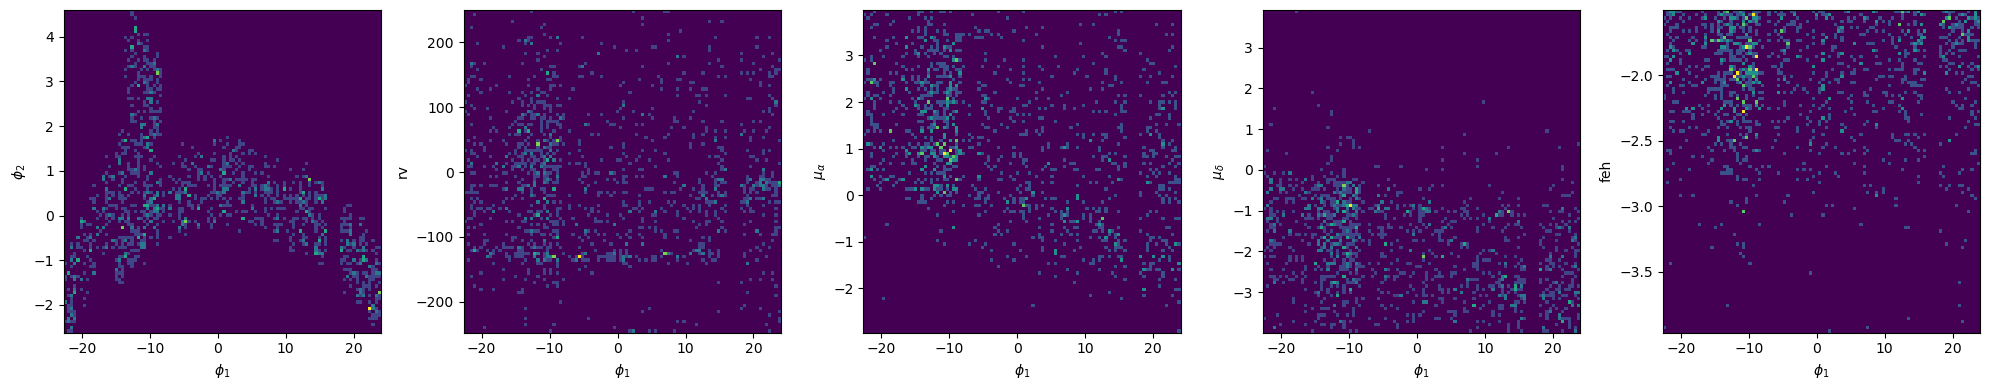

In [13]:
smlvis.coord_panels(
    data_real,
    coords=("phi2", "rv", "pmra", "pmdec", "feh"),
    use_hist=True,
    savefig=str(folder / "selection.png"),
)
plt.show();

### Building Isochrone

In [14]:
iso_drt = QTable.read(DATA / "atlas_dartmouth_11-5.dat", format='ascii.ecsv')

# manual adjustments
iso_drt['g'] = iso_drt['g'] + 0.088
iso_drt['r'] = iso_drt['r'] + 0.058

iso_drt['g-r'] = (iso_drt['g'])-(iso_drt['r'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


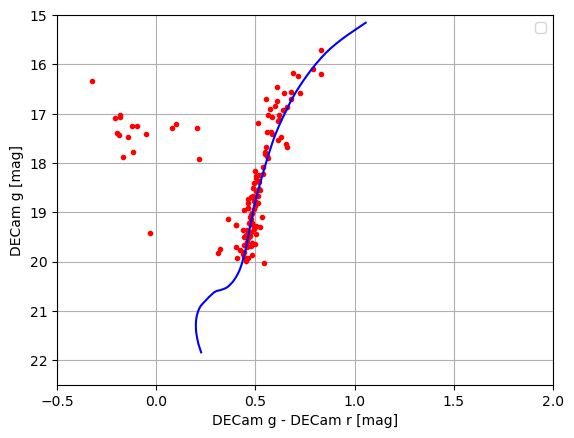

In [15]:
plt.plot(mdl_mem['decam_g']-mdl_mem['decam_r'], mdl_mem['decam_g'], c="red", marker='.', linestyle='none', alpha=1)
plt.plot(((iso_drt['g'])-(iso_drt['r']))[100:], (iso_drt['g']+17.1)[100:], c="blue")

plt.xlim(-0.5, 2)
plt.ylim((22.5, 15))
plt.grid(True)
plt.legend()
plt.xlabel('DECam g - DECam r [mag]')
plt.ylabel('DECam g [mag]')
plt.show();

## Defining Model

### Coordinate Names & Bounds

In [16]:
coord_astrometric_names = ("phi2", "rv", "pmra", "pmdec")
coord_astrometric_err_names = ("phi2_err", "rv_err", "pmra_err", "pmdec_err")
coord_photometric_names = ("g", "r")
coord_photometric_err_names = ("g_err", "r_err")

coord_names = coord_astrometric_names + coord_photometric_names

In [17]:
coord_bounds: dict[str, tuple[float, float]] = {
    k: (float(np.nanmin(data_real[k])), float(np.nanmax(data_real[k])))
    for k in coord_names
}

# make subselections
coord_astrometric_bounds = {k: coord_bounds[k] for k in coord_astrometric_names}
coord_photometric_bounds = {k: coord_bounds[k] for k in coord_photometric_names}

coord_bounds

{'phi2': (-2.6216100622361753, 4.598304777168021),
 'rv': (-247.6231033938883, 249.99681946071019),
 'pmra': (-2.952738239135585, 3.9751028539987727),
 'pmdec': (-3.997425139607703, 3.924411315003752),
 'g': (14.759774208068848, 20.260440826416016),
 'r': (14.881896018981934, 20.016958236694336)}

### Background Model

In [18]:
background_astrometric_model = sml.builtin.TruncatedSkewNormal(
    net=sml.nn.sequential(data=1, layers=5, hidden_features=128, dropout=0.15, features=3*len(coord_astrometric_names)),
    #net=sml.nn.sequential(n_in=1, n_hidden=128, n_layers=5, n_out=3 * len(coord_astrometric_names), dropout=0.15),
    data_scaler=scaler,
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["phi2"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["rv"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(4, 5),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["pmra"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(0.1, 0.7),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["pmdec"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-0.1, 0.35),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
        }
    ),
    require_where=True
)

In [19]:
#net=sml.nn.sequential(data=1, layers=5, hidden_features=128, dropout=0.15),

**Background Flow Training**

In [20]:
# Background
off_stream = (
    ((data["rv"] > -100) | (data["rv"] < -150))
    & where["g", "r"].array.all(-1)  # no NaN
)

In [21]:
num_layers = 4
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=3, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow_coords = ("phi1",) + coord_photometric_names
flow_scaler = scaler[flow_coords]  # slice the StandardScaler

bkg_flow = sml.builtin.compat.NFlowModel(
    net=Flow(transform, base_dist),
    jacobian_logdet=-xp.log(xp.prod(flow_scaler.scale[1:])),
    data_scaler=flow_scaler,
    coord_names=coord_photometric_names,
    coord_bounds=coord_photometric_bounds,
    params=ModelParameters(),
    require_where=True
)

In [22]:
# num_layers = 4
# base_dist = ConditionalDiagonalNormal(shape=[2], 
#                                       context_encoder=nn.Linear(1, 4))

# transforms = []
# for _ in range(num_layers):
#     transforms.append(ReversePermutation(features=2))
#     transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
#                                                           hidden_features=3, 
#                                                           context_features=1))
# transform = CompositeTransform(transforms)

# flow_coords = ("phi1",) + coord_photometric_names
# flow_scaler = scaler[flow_coords]  # slice the StandardScaler

# bkg_flow = sml.builtin.compat.ZukoFlowModel(
#     net=Flow(transform, base_dist),
#     jacobian_logdet=-xp.log(xp.prod(flow_scaler.scale[1:])),
#     data_scaler=flow_scaler,
#     coord_names=coord_photometric_names,
#     coord_bounds=coord_photometric_bounds,
#     params=ModelParameters(),
#     require_where=True
# )

In [23]:
torch_dataset = td.TensorDataset(data[flow_coords][off_stream].array,
                                 where[flow_coords][off_stream].array)
loader = td.DataLoader(dataset=torch_dataset, batch_size=200, shuffle=True, num_workers=0)
optimizer = optim.AdamW(bkg_flow.parameters(), lr=1e-3)

EPOCHS = 1_000

(folder / "flow").mkdir(exist_ok=True, parents=True)
bkg_flow.zero_grad()

# for epoch in tqdm(range(EPOCHS)):

#     for step, (data_cur, dat_where) in enumerate(loader):
#         data_cur = sml.Data(data_cur, names=flow_coords)
#         dat_where = sml.Data(dat_where, names=flow_coords)

#         optimizer.zero_grad()
#         mpars = bkg_flow.unpack_params(bkg_flow(data_cur))
#         loss = - bkg_flow.ln_likelihood_tot(mpars, data_cur, where=dat_where,)

#         loss.backward()
#         optimizer.step()
#         bkg_flow.zero_grad()

#         if epoch % 50 == 0 or epoch == EPOCHS - 1:
#             with xp.no_grad():
#                 mpars = bkg_flow.unpack_params(bkg_flow(data))
#                 lik = bkg_flow.likelihood(mpars, data, where=where,)

#             fig, ax = plt.subplots()
#             im = ax.scatter(data["g"]-data['r'], data["g"], s=1, c=lik)
#             ax.set_xlim((-0.7,1.5))
#             ax.set_ylim((21,14))
#             plt.colorbar(im, ax=ax)
#             fig.savefig(folder / "flow" / f"epoch_{epoch:05}.png")

#             plt.close(fig)

#             xp.save(bkg_flow.state_dict(), folder / "flow" / f"model_{epoch}.pt")

bkg_flow.load_state_dict(xp.load(folder / "flow" / f"model_{EPOCHS-1}.pt"))
object.__setattr__(bkg_flow, "with_grad", False)

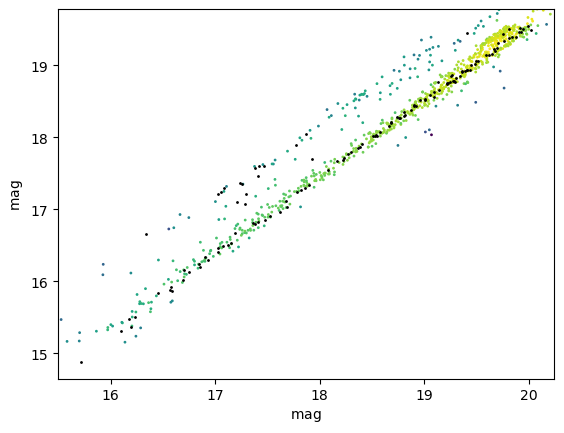

In [24]:
lik = bkg_flow.ln_likelihood(bkg_flow.unpack_params(bkg_flow(data)), data, where=where,)[off_stream]
plt.scatter(data['g'][off_stream], data['r'][off_stream], s=1, c=lik.numpy())
plt.scatter(mdl_mem['decam_g'], mdl_mem['decam_r'], s=1, c="k")

In [25]:
background_metal_model = sml.builtin.Exponential(
    net=sml.nn.sequential(data=1, layers=3, hidden_features=16, dropout=0.15, features=1),
    #net=sml.nn.lin_tanh(n_in=1, n_hidden=16, n_layers=3, n_out=1, dropout=0.15),
    data_scaler=scaler,
    coord_names=("feh", ),
    coord_err_names=('feh_err',),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters({"feh": {"slope": ModelParameter(bounds=SigmoidBounds(-2.0, -1.0), scaler=None)}}),
)

In [26]:
background_model = sml.IndependentModels(
        {
        "astrometric": background_astrometric_model,
        "metal": background_metal_model,
        "photometric": bkg_flow,
    }
)

### Stream Model

In [27]:
# Selection of control points
atlas_cp = QTable.read(DATA / "ATLAS_cp.ecsv")
atlas_control_points = sml.Data.from_format(atlas_cp, fmt="astropy.table", names=("phi1", "phi2", "rv", "pmra", "pmdec")).astype(xp.Tensor, dtype=xp.float32)

atlas_control_widths = sml.Data.from_format(atlas_cp, fmt="astropy.table",
                                            names=("w_phi2", "w_rv", "w_pmra", "w_pmdec"),
                                            renamer={"w_phi2": "phi2"}).astype(xp.Tensor, dtype=xp.float32)
atlas_control_widths = sml.Data(atlas_control_widths.array, names=("phi2", "rv", "pmra", "pmdec",))

atlas_control_points_prior = sml.prior.ControlRegions(
    center=atlas_control_points,
    lamda=10_000,  # TOO HIGH?
    width=atlas_control_widths,
)

In [28]:
# Selection of control points
au_cp = QTable.read(DATA / "AU_cp.ecsv")
au_control_points = sml.Data.from_format(au_cp, fmt="astropy.table", names=("phi1", "phi2", "rv", "pmra", "pmdec")).astype(xp.Tensor, dtype=xp.float32)

au_control_widths = sml.Data.from_format(au_cp, fmt="astropy.table", names=("w_phi2", "w_rv", "w_pmra", "w_pmdec")).astype(xp.Tensor, dtype=xp.float32)
au_control_widths = sml.Data(au_control_widths.array, names=("phi2", "rv", "pmra", "pmdec",))

au_control_points_prior = sml.prior.ControlRegions(
    center=au_control_points,
    lamda=10_000,  # TOO HIGH?
    width=au_control_widths,
)

In [29]:
ATLAS_astrometric_model = sml.builtin.TruncatedNormal(
    net=sml.nn.sequential(data=1, layers=5, hidden_features=128, dropout=0.15, features=2*len(coord_astrometric_names)),
    #net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2 * len(coord_astrometric_names), dropout=0.15),
    name='ATLAS_astrometric_model',
    data_scaler=scaler,
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, 2.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.4, 0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-145., 100.),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-1.6, 0.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, -0.5),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.2),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
            },
        }
    ),
    priors=(atlas_control_points_prior,)
)

In [30]:
AU_astrometric_model = sml.builtin.TruncatedNormal(
    net=sml.nn.sequential(data=1, layers=5, hidden_features=128, dropout=0.15, features=2*len(coord_astrometric_names)),
    #net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2 * len(coord_astrometric_names), dropout=0.15),
    name='AU_astrometric_model',
    data_scaler=scaler,
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, 4.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.4, 0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-145., -100.),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-0.5, 0.6),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-1.3, 0.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.2),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
            },
        }
    ),
    priors=(au_control_points_prior,)         
)

In [31]:
isochrone_spl = isochrone_spline(
    np.lib.recfunctions.structured_to_unstructured(iso_drt[['g', 'r']].as_array())[130:],
    xp=np
)

stream_abs_mags = np.lib.recfunctions.structured_to_unstructured(iso_drt[['g', 'r']].as_array())[130:]

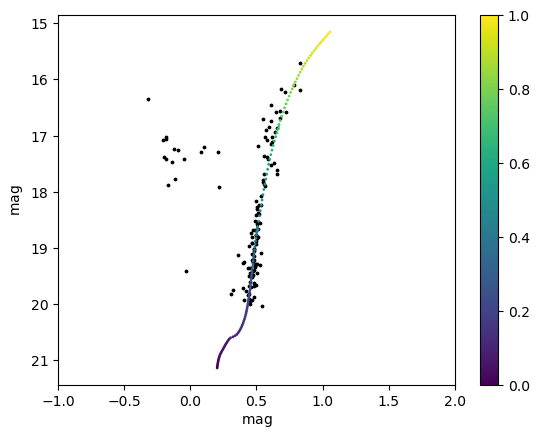

In [32]:
plt.scatter(mdl_mem["decam_g"] - mdl_mem['decam_r'],
            mdl_mem["decam_g"],
            s=3, c="k")
plt.scatter(stream_abs_mags[:,0] - stream_abs_mags[:,1],
            stream_abs_mags[:,0]+17.1,
            c=isochrone_spl.x, s=1)
plt.gca().invert_yaxis()
plt.xlim((-1.0,2))
plt.colorbar()

In [33]:
# Selection of control points
stream_control_points = sml.Data.from_format(bhb_mem, fmt="astropy.table", names=("phi1", "distmod_est"), renamer={'distmod_est':"distmod"}).astype(xp.Tensor, dtype=xp.float32)

stream_control_widths = sml.Data.from_format(bhb_mem, fmt="astropy.table", names=("w_distmod",)).astype(xp.Tensor, dtype=xp.float32)
stream_control_widths = sml.Data(stream_control_widths.array, names=("distmod",))

stream_control_points_prior = sml.prior.ControlRegions(
    center=stream_control_points,
    lamda=10_000,
    width=stream_control_widths,
)

In [34]:
phot_names = ("g", "r",)
phot_bounds = {k: (float(np.nanmin(data[k])), float(np.nanmax(data[k]))) for k in phot_names}

In [35]:
ATLAS_isochrone_model = sml.builtin.IsochroneMVNorm(
    net=sml.nn.sequential(data=1, layers=4, hidden_features=32, dropout=0.15, features=2),
    #net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    name='ATLAS_isochrone_model',
    # coordinates
    coord_names=('distmod',),
    coord_bounds={'distmod' : (14, 20),},
    # photometry
    phot_names=phot_names,
    phot_err_names=None,             #tuple(f"{k}_err" for k in phot_names),
    phot_apply_dm=(True, True),
    phot_bounds=phot_bounds,
    # isochrone
    gamma_edges=xp.linspace(isochrone_spl.x.min(), isochrone_spl.x.max(), 50),
    isochrone_spl=isochrone_spl,
    isochrone_err_spl=None,
#    stream_mass_function=...,
    # params
    params=ModelParameters({
        "distmod": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(10.0,21.0),
                    scaler=None,
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-5.0, 1.5),
                    scaler=None,
                ),
            },
        }
    ),
    priors=(stream_control_points_prior, ),
    require_where=True
)

In [36]:
AU_isochrone_model = sml.builtin.IsochroneMVNorm(
    net=sml.nn.sequential(data=1, layers=4, hidden_features=32, dropout=0.15, features=2),
    #net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    name='AU_isochrone_model',
    # coordinates
    coord_names=('distmod',),
    coord_bounds={'distmod' : (14, 20),},
    # photometry
    phot_names=phot_names,
    phot_err_names=None,             #tuple(f"{k}_err" for k in phot_names),
    phot_apply_dm=(True, True),
    phot_bounds=phot_bounds,
    # isochrone
    gamma_edges=xp.linspace(isochrone_spl.x.min(), isochrone_spl.x.max(), 50),
    isochrone_spl=isochrone_spl,
    isochrone_err_spl=None,
#    stream_mass_function=...,
    # params
    params=ModelParameters({
        "distmod": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(10.0,21.0),
                    scaler=None,
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-5.0, 1.5),
                    scaler=None,
                ),
            },
        }
    ),
    priors=(stream_control_points_prior, ),
)

In [37]:
from dataclasses import dataclass
from stream_ml.pytorch.utils import names_intersect
from stream_ml.pytorch import Data
from stream_ml.pytorch.typing import Array

@dataclass(unsafe_hash=True)
class FixedTruncatedNormal(sml.builtin.TruncatedNormal):
    net: None = None
    
    def __post_init__(self, *args):
        super().__post_init__(*args)
        self.register_parameter("mu", xp.nn.Parameter(xp.asarray(0, dtype=xp.float32), requires_grad=True))
        self.register_parameter("lnsigma", xp.nn.Parameter(xp.asarray(0, dtype=xp.float32), requires_grad=True))
    
    def forward(self, data: Data[Array]) -> Array:
        # The forward step runs on the normalized coordinates
        scaled_data = self.data_scaler.transform(
            data, names=names_intersect(data, self.data_scaler), xp=self.xp
        )
        # Output
        out = self.xp.zeros((len(data), 2))
        out[:, 0] = self.mu
        out[:, 1] = self.lnsigma
        return self._forward_priors(out, scaled_data)

In [38]:
ATLAS_metal_model = FixedTruncatedNormal(
    net=None,  # sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2, dropout=0.15)
    data_scaler=scaler["feh"],
    coord_names=('feh',),
    coord_err_names=("feh_err",),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters(
        {
            "feh": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-3.0, -1.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "feh", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.0, 1),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "feh", xp=xp),
                ),
            },
        }
    ),
)

In [39]:
AU_metal_model = FixedTruncatedNormal(
    net=None,  # sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2, dropout=0.15)
    data_scaler=scaler["feh"],
    coord_names=('feh',),
    coord_err_names=("feh_err",),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters(
        {
            "feh": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-3.0, -1.4),
                    scaler=StandardLocation.from_data_scaler(scaler, "feh", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.0, 1),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "feh", xp=xp),
                ),
            },
        }
    ),
)

In [40]:
ATLAS_model = sml.IndependentModels(
        {
        "astrometric": ATLAS_astrometric_model,
        "photometric": ATLAS_isochrone_model,
        "metal": ATLAS_metal_model,
    },
    name='ATLAS_model'
)

In [41]:
AU_model = sml.IndependentModels(
        {
        "astrometric": AU_astrometric_model,
        "photometric": AU_isochrone_model,
        "metal": AU_metal_model,
    },
    name='AU_model'
)

In [42]:
model = sml.MixtureModel(
    {
        "ATLAS": ATLAS_model,
        "AU": AU_model,
        "background": background_model
    },
    net=sml.nn.sequential(data=1, layers=4, hidden_features=32, dropout=0.15, features=2),
    #net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    params=ModelParameters(
        {
            "ATLAS.weight": ModelParameter(
                bounds=SigmoidBounds(1e-2, 0.3), scaler=None
            ),
            "AU.weight": ModelParameter(
                bounds=SigmoidBounds(1e-2, 0.3), scaler=None
            ),
            "background.weight": ModelParameter(
                bounds=ClippedBounds(0.35, 1.0), scaler=None
            ),
        }
    ),
    priors=(
        sml.prior.HardThreshold(1, upper=-15, param_name="ATLAS.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, lower=26, param_name="ATLAS.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, upper=-26, param_name="AU.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, lower=-7, param_name="AU.weight", coord_name="phi1", data_scaler=scaler),
        ## Add prior so AU PM must match ATLAS PM at threshold point
    ),
)
model.components.keys()

frozen_dict_keys(['ATLAS', 'AU', 'background'])

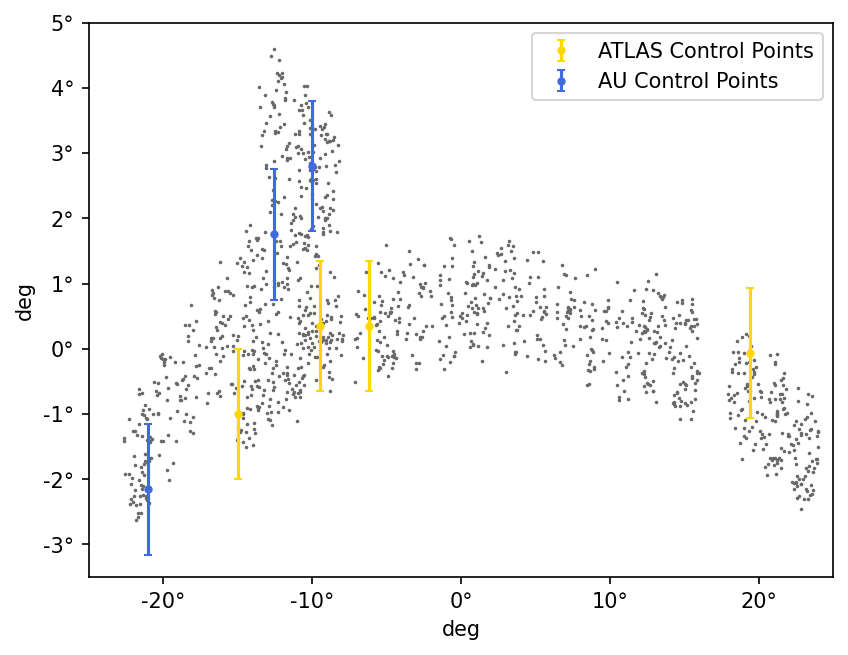

In [43]:
plt.figure(dpi=150)
plt.scatter(data['phi1'], data['phi2'], color='dimgrey', marker='.', s=2)
plt.errorbar(
    atlas_cp["phi1"],
    atlas_cp["phi2"],
    yerr=atlas_cp["w_phi2"],
    fmt=".",
    c="gold",
    capsize=2,
    label="ATLAS Control Points",
)
plt.errorbar(
    au_cp["phi1"],
    au_cp["phi2"],
    yerr=au_cp["w_phi2"],
    fmt=".",
    c="royalblue",
    capsize=2,
    label="AU Control Points",
)
plt.xlim((-25,25))
plt.ylim((-3.5, 5))
plt.legend()

In [44]:

from __future__ import annotations

__all__: list[str] = []

from dataclasses import KW_ONLY, dataclass
from typing import TYPE_CHECKING

import torch as xp

from stream_ml.core.prior import Prior

from stream_ml.pytorch.typing import Array, NNModel

if TYPE_CHECKING:
    from stream_ml.core import ModelAPI

    from stream_ml.pytorch import Data
    from stream_ml.pytorch.params import Params
    from stream_ml.pytorch.typing import ArrayNamespace


#####################################################################


def _atleast_2d(x: Array) -> Array:
    """Ensure that x is at least 2d."""
    if x.ndim == 0:
        return x[None, None]
    elif x.ndim == 1:
        return x[:, None]
    return x


@dataclass(frozen=True, repr=False)
class ParameterRegions(Prior[Array]):
    r"""Control regions prior.

    The gaussian control points work very well, but they are very informative.
    This prior is less informative, but still has a similar effect.
    It is a Gaussian, split at the peak, with a flat region in the middle.
    The split is done when the 1st derivative is 0, so it is smooth up to the
    1st derivative.

    .. math::

        \ln p(x, \mu, w) = \begin{cases}
            (x - (mu - w))^2 & x \leq mu - w \\
            0                & mu - w < x < mu + w \\
            (x - (mu + w))^2 & x \geq mu + w \\

    Parameters
    ----------
    other_model : ModelAPI
        The control points. These are the means of the regions (mu in the above).
    width : Data[Array], optional
        Width(s) of the region(s).
    lambda : float, optional
        Importance hyperparameter.
    """

    other_model: ModelAPI
    width: float | Data[Array] = 0.5
    lamda: float = 0.05
    _: KW_ONLY
    coord_name: str = "phi1"
    component_param_name: str = "mu"
    y_coord_names: tuple[str,...]

    array_namespace: ArrayNamespace[Array] = xp

    def __post_init__(self) -> None:
        """Post-init."""
        super().__post_init__()

        # Pre-store the control points, seprated by indep & dep parameters.
        self._x: Data[Array]
        object.__setattr__(self, "_x", self.other_model[(self.coord_name,)])
            
        # Pre-store the width.
        self._w: Array
        object.__setattr__(
            self,
            "_w",
            _atleast_2d(xp.squeeze(self.width[self.y_coord_names].array))
            if not isinstance(self.width, float)
            else xp.ones_like(self.width[y_coord_names].array) * self.width,
        )

    def logpdf(
        self,
        mpars: Params[Array],
        data: Data[Array],
        model: ModelAPI[Array, NNModel],
        current_lnpdf: Array | None = None,
        /,
    ) -> Array:
        """Evaluate the logpdf.

        This log-pdf is added to the current logpdf. So if you want to set the
        logpdf to a specific value, you can uses the `current_lnpdf` to set the
        output value such that ``current_lnpdf + logpdf = <want>``.

        Parameters
        ----------
        mpars : Params[Array], positional-only
            Model parameters. Note that these are different from the ML
            parameters.
        data : Data[Array], position-only
            The data for which evaluate the prior.
        model : Model, position-only
            The model for which evaluate the prior.
        current_lnpdf : Array | None, optional position-only
            The current logpdf, by default `None`. This is useful for setting
            the additive log-pdf to a specific value.

        Returns
        -------
        Array
            The logpdf.
        """
        # Get model parameters evaluated at the control points. shape (C, 1).
        cmpars = model.unpack_params(model(self._x))  # type: ignore[call-overload]  # noqa: E501
        cmp_arr = xp.stack(  # (C, F)
            tuple(cmpars[(n, self.component_param_name)] for n in self.y_coord_names), 1
        )
        # Other model prediction
        cmpars_other = self.other_model.unpack_params(self.other_model(self._x))  # type: ignore[call-overload]  # noqa: E501
        cmp_arr_other = xp.stack(  # (C, F)
            tuple(cmpars_other[(n, self.component_param_name)] for n in self.y_coord_names), 1
        )
        
        lnpdf = xp.zeros_like(cmp_arr)


        # Lower side
        # Note that comparison to NaN is always False.
        where = cmp_arr <= cmp_arr_other - self._w
        lnpdf[where] = (cmp_arr[where] - (cmp_arr_other[where] - self._w[where])) ** 2

        # Upper side
        where = cmp_arr >= cmp_arr_other + self._w
        lnpdf[where] = (cmp_arr[where] - (cmp_arr_other[where] + self._w[where])) ** 2

        return -self.lamda * self.xp.sum(lnpdf)  # (C, F) -> 1

In [45]:
#ParameterRegions(AU_model, coord_name='phi1', component_param_name='mu', y_coord_names=('pmra', 'pmdec', 'rv'))

for forward call, we need to assert that the two diff. streams have identical param values **at cutoff threshold** (i.e. find right index)

### Combined Model

In [46]:
EPOCHS = 20_000  # 5k w/out dropout, 10k with
BATCH_SIZE = int(len(data) * 0.075)

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

In [47]:
dataset = td.TensorDataset(
    data.array,  # data
    where.array,  # mask: TRUE where NOT missing
)

loader = td.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,  # drop rando last for better plotting
)

optimizer = optim.AdamW(
    list(model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1_250, eta_min=1e-5)

In [48]:
(folder / "training").mkdir(parents=True, exist_ok=True)

slopes = np.full((EPOCHS // 100, len(coord_astrometric_names), BATCH_SIZE), np.nan)

num_steps = len(loader.dataset) // loader.batch_size
epoch: int = 0
# for epoch in tqdm(range(EPOCHS)):

#     for step, (step_arr, dat_where) in enumerate(loader):

#         # Prepare
#         step_data = sml.Data(step_arr, names=data.names)
#         dat_where = sml.Data(dat_where, names=data.names)

#         # Forward Step
#         pred = model(step_data)
#         if pred.isnan().any(): raise ValueError

#         mpars = model.unpack_params(pred)
#         loss_val = -model.ln_posterior_tot(
#             mpars,
#             step_data,
#             where=dat_where,
#         )

#         # backward pass
#         optimizer.zero_grad()
#         loss_val.backward()

#         # update weights
#         optimizer.step()
#         scheduler.step(epoch + step / num_steps)

#         model.zero_grad()  # ?

#     if epoch % 100 == 0 or epoch == EPOCHS - 1:
#         model.eval()  # turn off training for nicer plot
        
#         with xp.no_grad():
#             mpars = model.unpack_params(model(data))

#         fig = smlvis.astrometric_model_panels(
#             model,
#             data,
#             mpars,
#             coords=("phi2","rv", "pmra", "pmdec"),
#             components=("ATLAS.astrometric", "AU.astrometric"),
#             min_weight=1e-3,
#             figsize=(12, 4),
#             top_legend_fontsize=8,
#             savefig=folder / "training" / f"epoch-{epoch:05}.png",
#         )
#         plt.close(fig)

#         model.train()  # turn training back on

#     # Serialize
#     if epoch % 500 == 0 or epoch == EPOCHS - 1:
#         xp.save(model.state_dict(), folder / "training" / f"model_{epoch:05}.pt")

model.load_state_dict(xp.load(folder / "training" / f"model_{EPOCHS - 1:05}.pt"))

<All keys matched successfully>

# Plotting

In [49]:
# # Get predictions
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    ATLAS_lnlik = model.component_ln_likelihood("ATLAS", mpars, data, where=where)
    AU_lnlik = model.component_ln_likelihood("AU", mpars, data, where=where)
    tot_lnlik = model.ln_likelihood(mpars, data, where=where)

stream_prob = np.exp(ATLAS_lnlik - tot_lnlik) + np.exp(AU_lnlik - tot_lnlik)
ATLAS_prob = np.exp(ATLAS_lnlik - tot_lnlik)
AU_prob = np.exp(AU_lnlik - tot_lnlik)

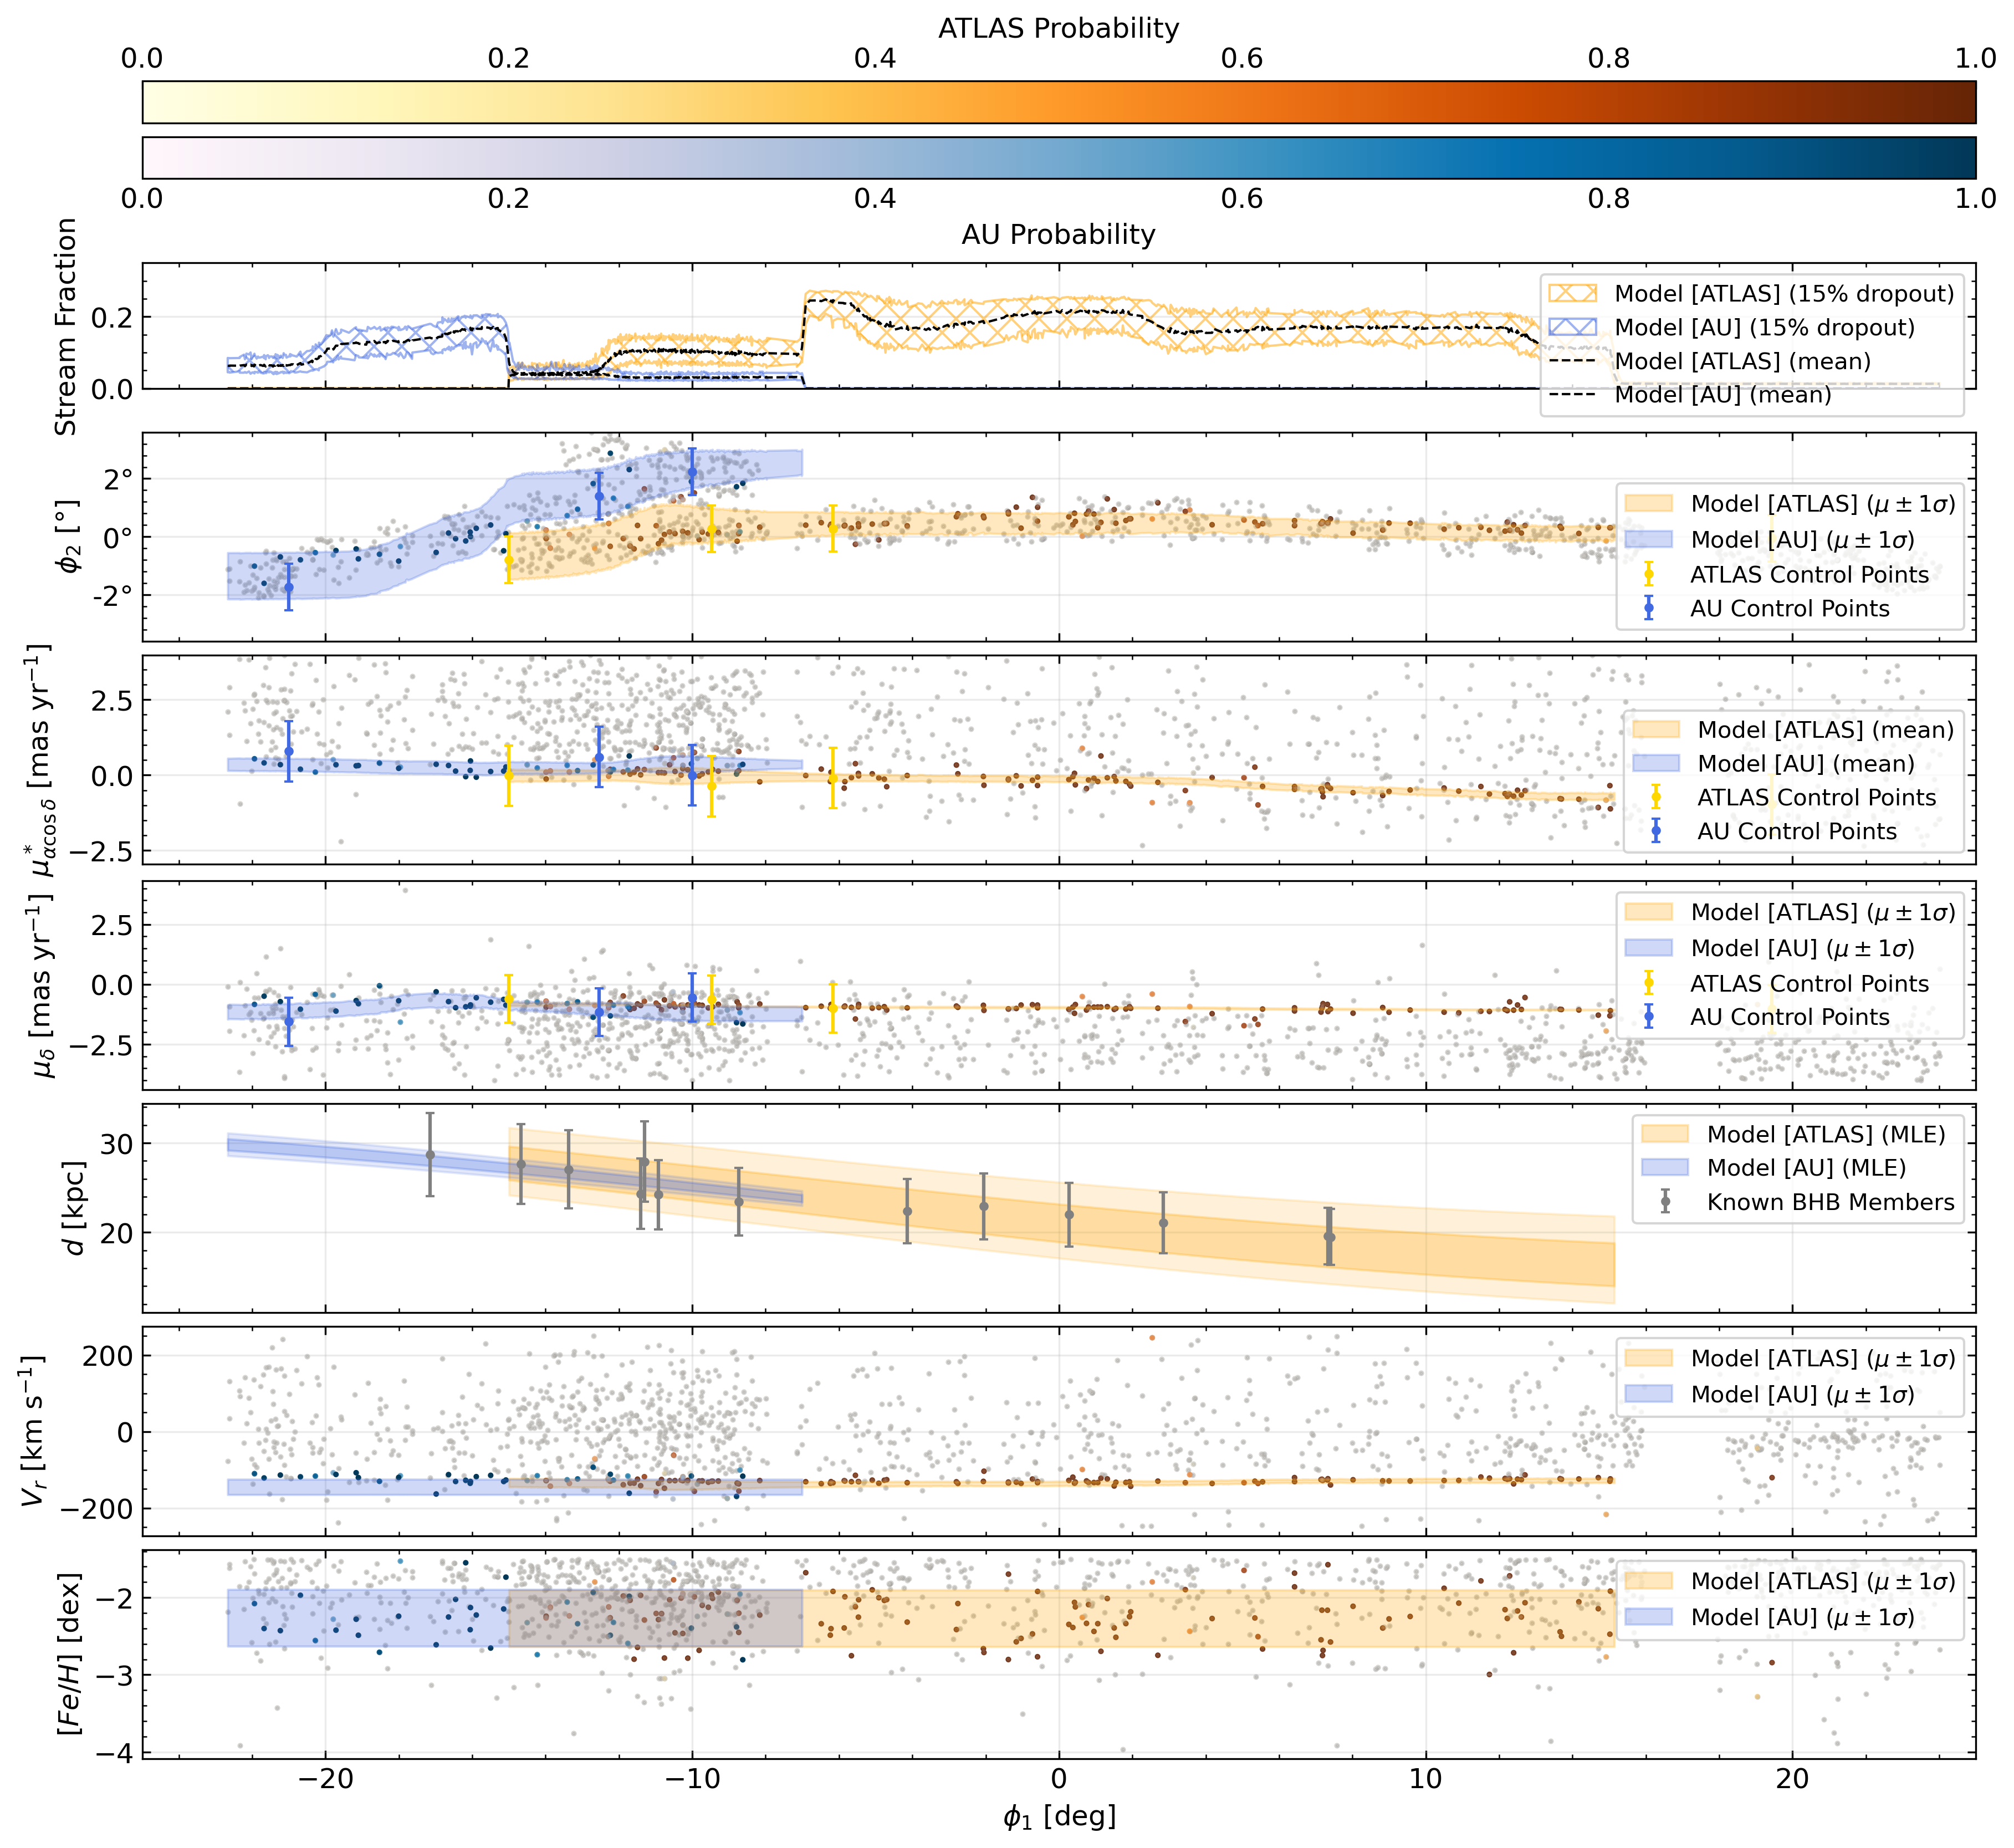

In [50]:
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from helper2 import plot_ATLAS
plt.style.use("~/stream_ml/paper.mplstyle")

# Evaluate model
model = model.eval()
fig = plot_ATLAS(model, data, where)
plt.show()

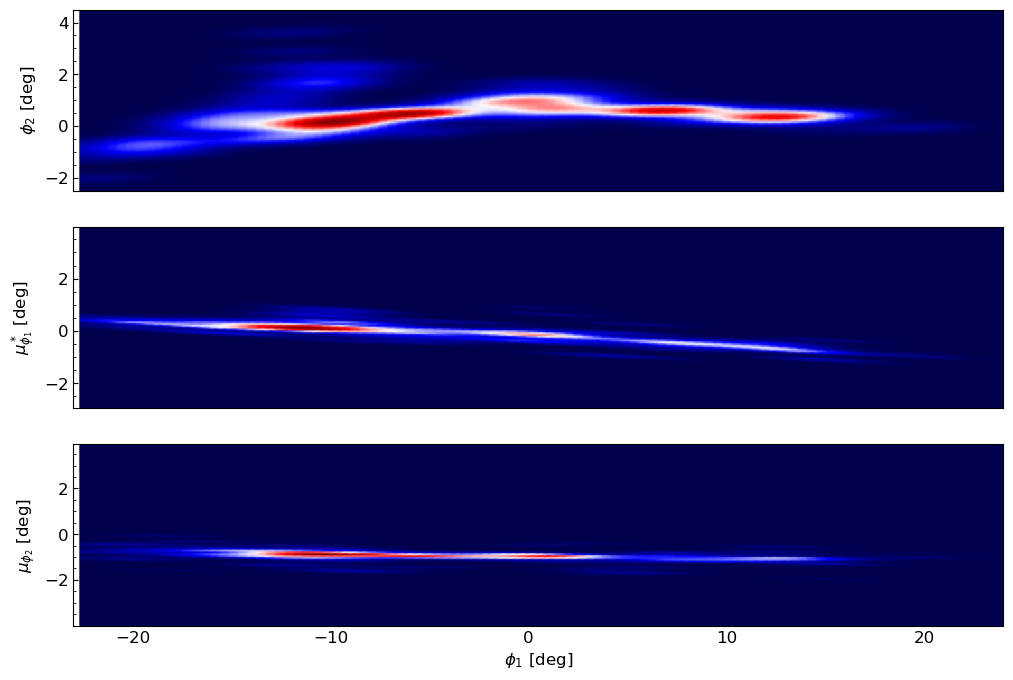

In [51]:
from helper3 import plot_ATLAS_KDE_tot, plot_ATLAS_KDE_s1, plot_ATLAS_KDE_s2
plot_ATLAS_KDE_tot(model, data, where)

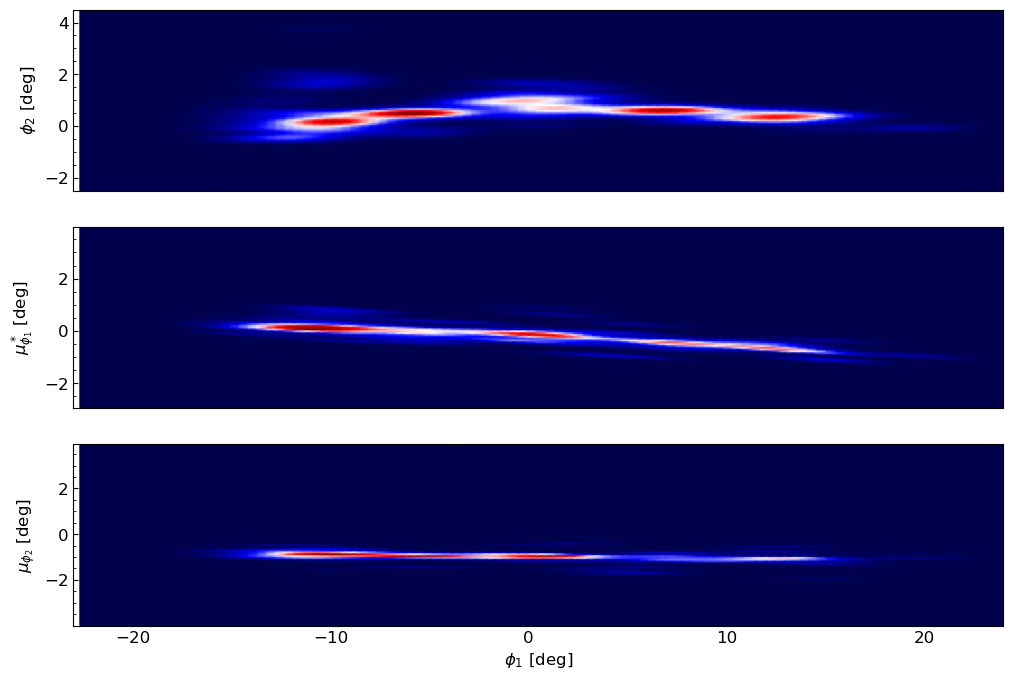

In [52]:
plot_ATLAS_KDE_s1(model, data, where)

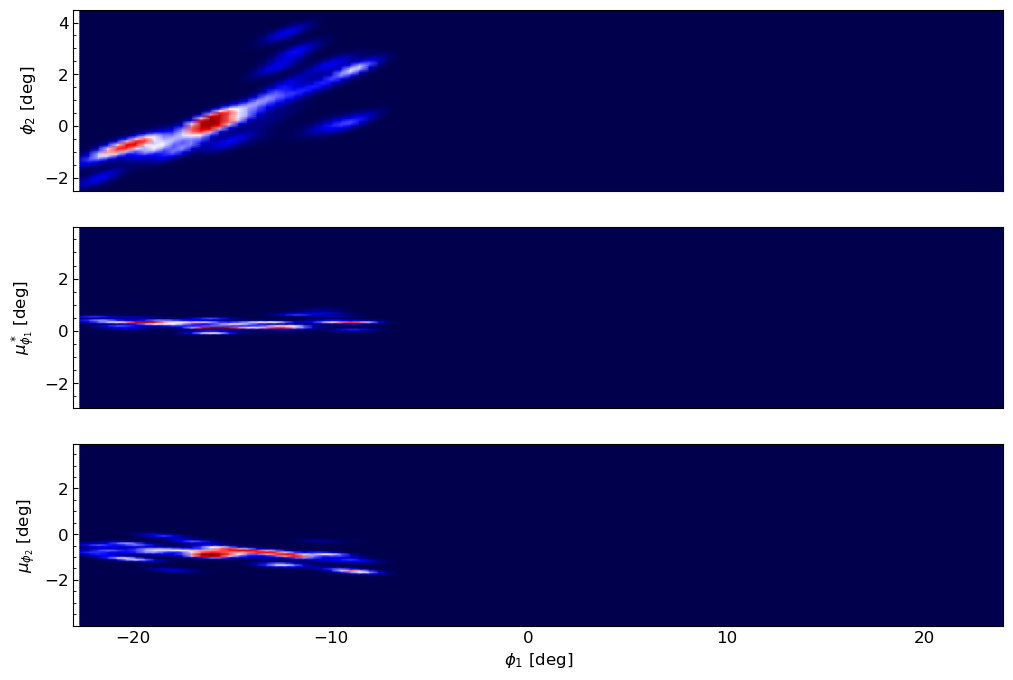

In [53]:
plot_ATLAS_KDE_s2(model, data, where)

In [54]:
test_ATLAS = atlas_data_red[stream_prob.numpy() > 0.95]

(-25.0, 25.0)

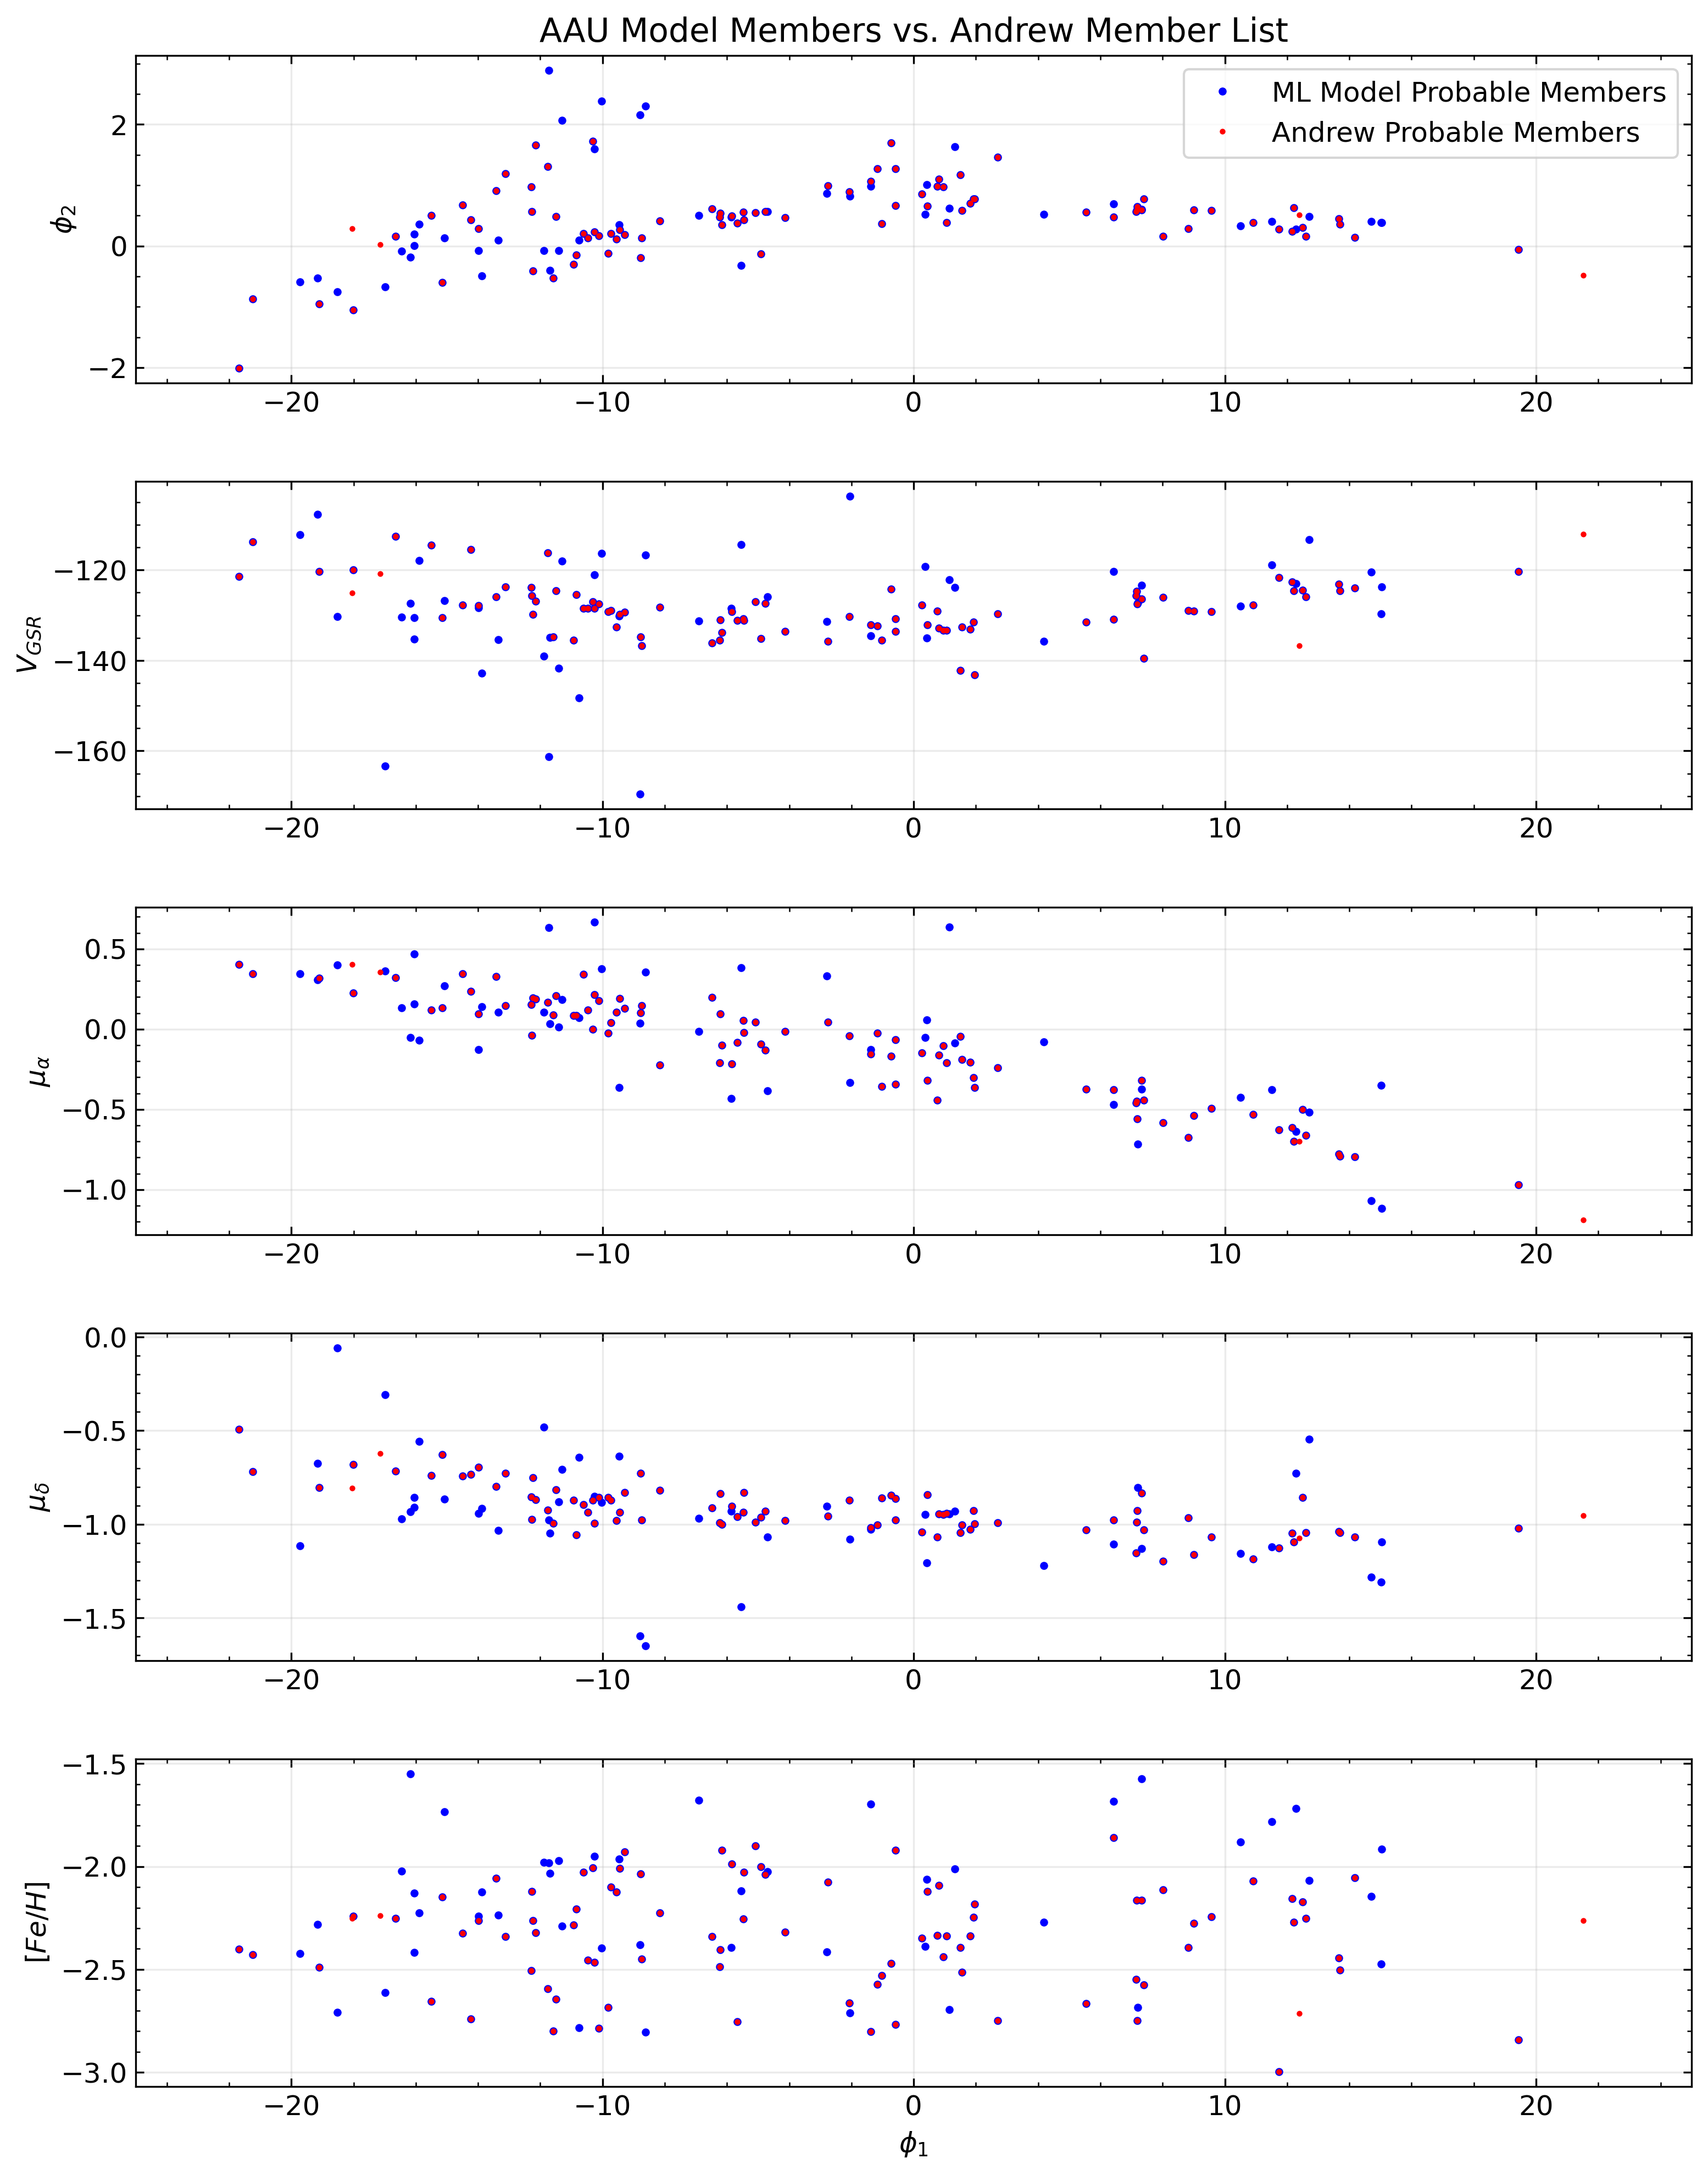

In [55]:
fig = plt.figure(dpi=300, figsize=(8,16))

gs1 = plt.GridSpec(5, 1, left=0.05, right=1.23, hspace=0.30)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
ax4 = fig.add_subplot(gs1[3,0])
ax5 = fig.add_subplot(gs1[4,0])

ax1.plot(test_ATLAS['phi1'], test_ATLAS['phi2'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5, label='ML Model Probable Members')
ax1.plot(li_mem['phi1'], li_mem['phi2'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3, label='Andrew Probable Members')

ax2.plot(test_ATLAS['phi1'], test_ATLAS['vgsr'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax2.plot(li_mem['phi1'], li_mem['vgsr'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)

ax3.plot(test_ATLAS['phi1'], test_ATLAS['pmra'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax3.plot(li_mem['phi1'], li_mem['pmra'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)

ax4.plot(test_ATLAS['phi1'], test_ATLAS['pmdec'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax4.plot(li_mem['phi1'], li_mem['pmdec'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)

ax5.plot(test_ATLAS['phi1'], test_ATLAS['feh50'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax5.plot(li_mem['phi1'], li_mem['feh50'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\\mu_{\\alpha}$')
ax4.set_ylabel('$\\mu_{\\delta}$')
ax5.set_ylabel('$[Fe/H]$')
ax5.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model Members vs. Andrew Member List')
ax1.legend()
ax1.set_xlim((-25, 25))
ax2.set_xlim((-25, 25))
ax3.set_xlim((-25, 25))
ax4.set_xlim((-25, 25))
ax5.set_xlim((-25, 25))

In [56]:
test_AU = atlas_data_red[AU_prob.numpy() > 0.95]

In [57]:
### ADD .value for plotting to get rid of the "deg"

In [58]:
from helper4 import plot_AAU_comparison
fig = plot_AAU_comparison(model, data, where)
plt.show()

ModuleNotFoundError: No module named 'stream_ml.pytorch.builtin.compat.flow'

In [ ]:
li_mem

In [ ]:
from helper5 import plot_AAU_comparison2
fig2 = plot_AAU_comparison2(model, data, where)
plt.show()

In [ ]:
### char.ax.text(0.5, 0.5, ha='center', va='center') to put "Stream Probability" label in CB